# 2. Higgs@L3_Logistic_Regression

## Prerequisites

The BDTs are used as a precut and must thus be already available.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression

from  higgs_search.helpers import higgs_hypotheses, log_reg_coeffs_dir, symbol
from higgs_search.load_data import getTrainAndTest
from higgs_search.plotting import confusionMatrix

## Data preparation

As mentioned above, the BDT response is used for a precut on the data.
We want to ignore the `mmis` variable.
It is identified as a strong discriminator.
It is nevertheless not used in the Classifier.
Instead, it will later be used, together with the Classifier's response, in a 2D analysis.

### Upweighting the signal

The vast majority of events is background events. When using the weighted events, the best classifier will simply classify any event as background.
We will upweight the signal such that the same total weight is given to the used background events as to the signal events.

In [2]:
X_train, X_test, y_train, y_test, X_train_w, X_test_w = getTrainAndTest("higgs_85", bdt_precut=True, drop=["mmis"], upweight_signal=True)

## Train a Logistic Regression

This is executed & evaluated for each of the mass hypothesis.
The coefficients are saved in a plain `.txt` file.

In [3]:
best_c = 0
best_test_score = 0
for c in [10**x for x in [-5, -2, 0, 2, 5, 7, 10]]:
    lr = LogisticRegression(C=c).fit(X_train, y_train, sample_weight=X_train_w)
    test_score = lr.score(X_test, y_test, sample_weight=X_test_w)
    print(f"Regularization with C={c:.0e}. Test set score = {100*test_score:.2f} %.")
    if test_score > best_test_score:
        best_test_score = test_score
        best_c = c

Regularization with C=1e-05. Test set score = 70.13 %.
Regularization with C=1e-02. Test set score = 80.49 %.
Regularization with C=1e+00. Test set score = 83.44 %.
Regularization with C=1e+02. Test set score = 83.94 %.
Regularization with C=1e+05. Test set score = 83.82 %.
Regularization with C=1e+07. Test set score = 83.60 %.
Regularization with C=1e+10. Test set score = 83.66 %.


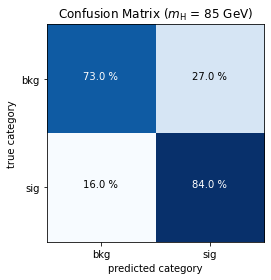

higgs_85 training score: 83.42 %.
higgs_85 test set score: 83.94 %.



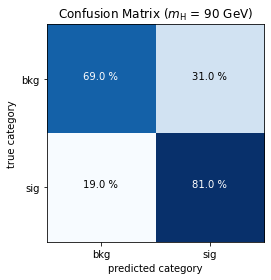

higgs_90 training score: 81.67 %.
higgs_90 test set score: 80.77 %.



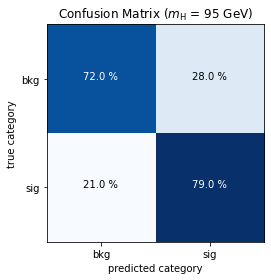

higgs_95 training score: 82.24 %.
higgs_95 test set score: 79.80 %.



In [4]:
log_regs = {}
for higgs_mass in higgs_hypotheses:
    X_train, X_test, y_train, y_test, X_train_w, X_test_w = getTrainAndTest(higgs_mass, bdt_precut=True, drop=["mmis"], upweight_signal=True)
    log_regs[higgs_mass] = LogisticRegression(C=best_c).fit(X_train, y_train, sample_weight=X_train_w
    )

    y_pred = log_regs[higgs_mass].predict(X_test)
    confusionMatrix(y_pred, y_test)
    plt.title(f"Confusion Matrix ($m_\mathrm{{H}}$ = {higgs_mass[-2:]} GeV)")
    plt.show()

    print(f"{higgs_mass} training score: {100*log_regs[higgs_mass].score(X_train, y_train, sample_weight=X_train_w):.2f} %.")
    print(f"{higgs_mass} test set score: {100*log_regs[higgs_mass].score(X_test, y_test, sample_weight=X_test_w):.2f} %.\n")

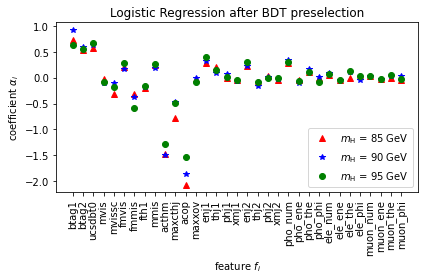

In [8]:
for higgs_mass, log_reg in log_regs.items():
    plt.plot(log_reg.coef_.T, symbol[higgs_mass], 
             label=f"$m_\mathrm{{H}}$ = {higgs_mass[-2:]} GeV")
plt.title("Logistic Regression after BDT preselection")
plt.xlabel("feature $f_i$")
plt.ylabel("coefficient $\\alpha_i$")
plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig("plots/logisitic_regression_coefficients.png", facecolor="white")

## Save the model coefficients and the intercepts for future usage

Only save them if no other coefficients were saved yet, to avoid overwriting.

In [6]:
for higgs_mass, log_reg in log_regs.items():
    coefs = np.concatenate([log_reg.coef_[0], log_reg.intercept_])
    log_reg_coeffs_dir.mkdir(parents=True, exist_ok=True)
    if not (log_reg_coeffs_dir / f"{higgs_mass}.txt").exists():
        np.savetxt(log_reg_coeffs_dir / f"{higgs_mass}.txt", coefs)